In [1]:
# Data Preprocessing and Visualization
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# CNN Building and Training
import torch
import torch.nn as nn
import torch.optim as optim

# Others
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Visualization

In this section, we will delve into both the dataset's size and its class distribution. This exploration will be facilitated by visualizing a pie chart. Notably, the dataset comprises four distinct classes, each having its dedicated folder. Additionally, it's important to mention that the training and test sets are segregated into separate folders, allowing for distinct analyses.

In [2]:
train_file = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_file = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

# store training data
train_labels = []

for label in os.listdir(train_file):
    for image in os.listdir(train_file + label):
        train_labels.append(label)

# store test data labels
test_labels = []

for label in os.listdir(test_file):
    for image in os.listdir(test_file + label):
        test_labels.append(label)


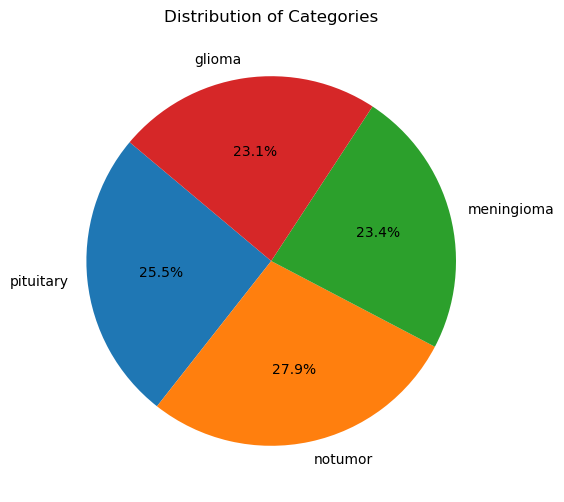

In [3]:
# Find class ratio of training data

# Count occurrences using Counter {label: occurence}
value_counts = Counter(train_labels)

# Extract labels and values for the pie chart
labels = list(value_counts.keys())
values = list(value_counts.values())

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

plt.title('Distribution of Categories')
plt.show()

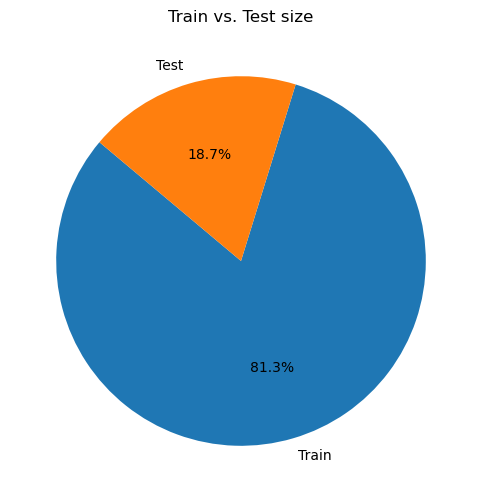

In [4]:
# Sample size comparison between train and test

list_lengths = [len(train_labels), len(test_labels)]

train_test_labels = ['Train', 'Test']


# Pie chart: Train vs. Test size
plt.figure(figsize=(6, 6))
plt.pie(list_lengths, labels=train_test_labels, autopct='%1.1f%%', startangle=140)
plt.title('Train vs. Test size')
plt.show()

The training set maintains a balanced class ratio, while also adhering to an approximate 80:20 split between the sample sizes of the training and test sets.

### Data Augmentation

To enhance the dataset and improve model generalization, a data augmentation pipeline is employed. This pipeline involves a series of transformations applied to the images before feeding them into the model. The transformations include:

1. **Resize**: Images are resized to a consistent size of 224x224 pixels.
2. **Random Horizontal Flip**: Images are randomly flipped horizontally, introducing variations in orientation.
3. **Random Rotation**: Images undergo random rotations of up to 10 degrees, contributing to diversity.
4. **To Tensor**: Images are converted into PyTorch tensors, the format required for model input.
5. **Normalize**: Pixel values are normalized to facilitate efficient training. The mean and standard deviation values for each color channel are as follows:

   - Mean values: [0.485, 0.456, 0.406]
   - Standard deviation values: [0.229, 0.224, 0.225]
   
These transformations collectively enhance the dataset's richness, ensuring the model learns from a diverse range of image variations while maintaining consistency and stability.

In [5]:
# Data augmentation
trans_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224 pixels
    transforms.RandomHorizontalFlip(),      # Randomly flip images horizontally
    transforms.RandomRotation(10),          # Randomly rotate images up to 10 degrees
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize(                   # Normalize pixel values
        mean=[0.485, 0.456, 0.406],         # Mean values for each color channel
        std=[0.229, 0.224, 0.225]           # Standard deviation values for each color channel
    )
])

# Create train dataset and data loader
train_dataset = ImageFolder(train_file, transform=trans_pipeline)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create test dataset and data loader
test_dataset = ImageFolder(test_file, transform=trans_pipeline)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

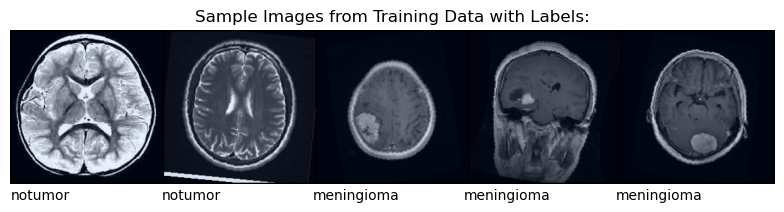

In [6]:
import torchvision.utils as vutils
# Visualize some samples from training set
# Get a batch of images and labels from the train_loader
data_batch, labels_batch = next(iter(train_loader))

# Select 5 images and their corresponding labels
selected_images = data_batch[:5]
selected_labels = labels_batch[:5]

# Create a grid of images
grid = vutils.make_grid(selected_images, nrow=5, normalize=True)

# Create a list of category names based on the class indices
category_names = train_dataset.classes

# Display the grid
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0))
# an image tensor with shape (batch_size, channels, height, width):
# for matplotlib: height becomes first dim, width becomes second dim, channels becomes third dim

plt.axis('off')  # Turn off axis labels and ticks
plt.title('Sample Images from Training Data with Labels:')
for i, label_idx in enumerate(selected_labels):
    label_name = category_names[label_idx]
    plt.text(i * 224, 250, f"{label_name}", fontsize=10)
plt.show()

## Model Building (CNN)

The model consists of two main parts:

**Feature Extraction Part (`features` Sequential):**

- A convolutional layer with 3 input channels and 16 output channels using a 3x3 kernel.
- A ReLU activation function applied element-wise.
- A max pooling layer that reduces the spatial dimensions by half (2x2 kernel with stride 2).
- Another convolutional layer with 16 input channels and 32 output channels using a 3x3 kernel.
- A ReLU activation function applied element-wise.
- Another max pooling layer that again reduces the spatial dimensions by half.

**Classification Part (`classifier` Sequential):**

- A fully connected (linear) layer that flattens the feature map from the last convolutional layer and maps it to a hidden layer of size 128.
- A ReLU activation function applied element-wise.
- Another fully connected (linear) layer that maps the hidden layer to the output layer with `num_classes` neurons.

In [8]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Define CNN Architecture
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),  # Adjust input size based on image size
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.classifier(x)
        return x

In [10]:
# Define model, loss function, and optimizer
num_classes = len(train_dataset.classes)
model = BrainTumorClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Train the model
num_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

Epoch 1/10, Loss: 0.6649609548287565
Epoch 2/10, Loss: 0.33383858825291407
Epoch 3/10, Loss: 0.22509609072805703
Epoch 4/10, Loss: 0.16260836664482908
Epoch 5/10, Loss: 0.12162398454910588
Epoch 6/10, Loss: 0.11434149375597552
Epoch 7/10, Loss: 0.08074920243030566
Epoch 8/10, Loss: 0.06119440354899887
Epoch 9/10, Loss: 0.053848173654607576
Epoch 10/10, Loss: 0.04965106157051349


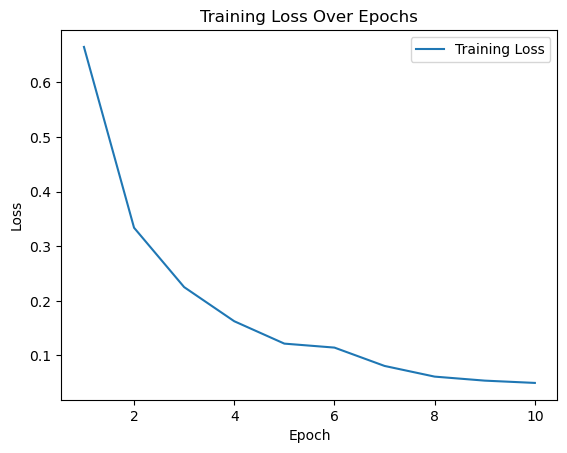

In [12]:
# Plot the training losses
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'tumor_classifier_model.pth')

In [13]:
# Evaluate the model on the test set
model.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_samples
print(f"Accuracy on test dataset: {accuracy:.2%}")


Accuracy on test dataset: 95.96%


In conclusion, the trend of decreasing training loss over epochs aligns with the observed accuracy of 95.96% achieved on the test dataset.